#### Sentiment polarity dataset
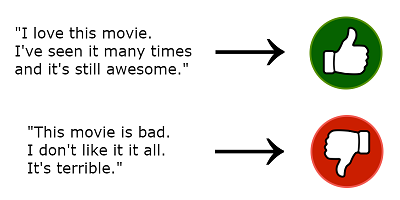

https://www.cs.cornell.edu/people/pabo/movie-review-data/


https://christophm.github.io/interpretable-ml-book/shap.html

https://github.com/slundberg/shap

In [123]:
import pandas as pd
import numpy as np 
import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt, seaborn as sb
import os
from glob import glob

# nltk.download('stopwords')
# nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")

# !pip install swifter
import swifter

In [124]:
pos_files = glob('../Data/txt_sentoken/pos/*')
neg_files = glob('../Data/txt_sentoken/neg/*')

def read_txt(FilePath):
    with open(FilePath,'r') as fp:
        txt = fp.read()
    return txt

POS_TXTS = [read_txt(fp) for fp in pos_files]
NEG_TXTS = [read_txt(fp) for fp in neg_files]

In [125]:
len(pos_files),len(neg_files)

(1000, 1000)

In [126]:
# text | target
# ...  | 1/0
Datax = pd.DataFrame(list(zip(POS_TXTS , [1]*len(POS_TXTS))) + list(zip(NEG_TXTS , [0]*len(NEG_TXTS))),
            columns =['text','target'])
Datax.head()

,text,target
0,films adapted from comic books have had plenty...,1
1,every now and then a movie comes along from a ...,1
2,you've got mail works alot better than it dese...,1
3,""" jaws "" is a rare film that grabs your atten...",1
4,moviemaking is a lot like being the general ma...,1


<AxesSubplot:ylabel='target'>

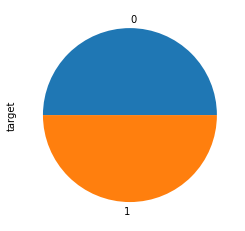

In [127]:
Datax.target.value_counts().plot(kind='pie')

In [128]:
Datax.text = Datax.text.str.lower()
Datax.text = Datax.text.str.strip(' ')
Datax.text = Datax.text.swifter.apply(lambda x:re.sub('[^a-zA-Z]',' ',x))
Datax.text = Datax.text.swifter.apply(lambda x:re.sub(' +',' ',x))

Datax.text

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

0       films adapted from comic books have had plenty...
1       every now and then a movie comes along from a ...
2       you ve got mail works alot better than it dese...
3        jaws is a rare film that grabs your attention...
4       moviemaking is a lot like being the general ma...
                              ...                        
1995    if anything stigmata should be taken as a warn...
1996    john boorman s zardoz is a goofy cinematic deb...
1997    the kids in the hall are an acquired taste it ...
1998    there was a time when john carpenter was a gre...
1999    two party guys bob their heads to haddaway s d...
Name: text, Length: 2000, dtype: object

In [67]:
sw = stopwords.words('english')
lem = WordNetLemmatizer()
ps = nltk.stem.PorterStemmer()

from nltk.corpus import wordnet
def get_pos(x):
    if x.startswith('J'):
        return wordnet.ADJ
    elif x.startswith('V'):
        return wordnet.VERB
    elif x.startswith('N'):
        return wordnet.NOUN
    elif x.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def token_process(text,stem=True):
    tokens = word_tokenize(text)
    tokens = list(filter(lambda x:x not in sw , tokens))
    if stem:
        tokens = [ps.stem(t) for t in tokens]
    else:
        tokens = [lem.lemmatize(t,get_pos(pt)) for t,pt in pos_tag(tokens)]
    
    processed_text = ' '.join(tokens)
    return processed_text

In [129]:
Datax.text = Datax.text.swifter.apply(lambda x:token_process(x,True))

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

### EDA

In [72]:
Datax.head() 

,text,target
0,film adapt comic book plenty success whether s...,1
1,every movie come along suspect studio every in...,1
2,get mail work alot good deserves order make fi...,1
3,jaw rare film grab attention show single image...,1
4,moviemaking lot like general manager nfl team ...,1


In [81]:
POS_WORDS = ' '.join(Datax[Datax.target==1].text.values.tolist())
POS_WORDS = POS_WORDS.split()

NEG_WORDS = ' '.join(Datax[Datax.target==0].text.values.tolist())
NEG_WORDS = NEG_WORDS.split()

In [82]:
len(POS_WORDS), len(NEG_WORDS)

(371976, 330448)

In [83]:
nltk.FreqDist(POS_WORDS).most_common(10)

[('film', 6168),
 ('movie', 3163),
 ('one', 3156),
 ('make', 2175),
 ('character', 2064),
 ('like', 1931),
 ('see', 1788),
 ('get', 1734),
 ('time', 1576),
 ('go', 1478)]

In [84]:
nltk.FreqDist(NEG_WORDS).most_common(10)

[('film', 4980),
 ('movie', 3818),
 ('one', 2874),
 ('make', 2085),
 ('like', 2009),
 ('get', 1993),
 ('character', 1815),
 ('go', 1564),
 ('time', 1427),
 ('even', 1402)]

In [87]:
POS_DIST = pd.DataFrame(nltk.FreqDist(POS_WORDS).items(), columns= ['word','wordcount_pos'])
POS_DIST = POS_DIST.set_index('word')

NEG_DIST = pd.DataFrame(nltk.FreqDist(NEG_WORDS).items(), columns= ['word','wordcount_neg'])
NEG_DIST = NEG_DIST.set_index('word')


POS_DIST.head()

,wordcount_pos
word,
film,6168
adapt,37
comic,227
book,228
plenty,76


In [88]:
NEG_DIST.head()

,wordcount_neg
word,
plot,978
two,912
teen,110
couple,248
go,1564


In [93]:
COM_DIST = POS_DIST.join(NEG_DIST)
COM_DIST.fillna(1)
COM_DIST = COM_DIST[(COM_DIST.wordcount_pos + COM_DIST.wordcount_neg)>50]
COM_DIST['ratio'] = np.log(COM_DIST.wordcount_pos/COM_DIST.wordcount_neg)

COM_DIST.head()

,wordcount_pos,wordcount_neg,ratio
word,,,
film,6168,4980.0,0.213945
adapt,37,19.0,0.666479
comic,227,175.0,0.260164
book,228,198.0,0.141079
plenty,76,58.0,0.270290


In [95]:
COM_DIST.sort_values(by ='ratio',ascending= False).head(20)

,wordcount_pos,wordcount_neg,ratio
word,,,
mulan,96,1.0,4.564348
flynt,79,1.0,4.369448
lebowski,55,1.0,4.007333
bulworth,58,2.0,3.367296
damon,69,4.0,2.847812
truman,152,11.0,2.625985
outstanding,69,5.0,2.624669
derek,62,7.0,2.181224
jedi,71,9.0,2.065455


In [97]:
COM_DIST.sort_values(by ='ratio',ascending= True).head(30)

,wordcount_pos,wordcount_neg,ratio
word,,,
seagal,2,74.0,-3.610918
schumacher,3,54.0,-2.890372
godzilla,14,120.0,-2.148434
worst,7,60.0,-2.148434
lame,15,102.0,-1.916923
poorly,14,80.0,-1.742969
waste,42,229.0,-1.696052
ridiculous,22,118.0,-1.679642
awful,21,111.0,-1.665008



## Text Preprocessing

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate __how important a word is to a document in a collection of documents__.

After removing __punctuation__ and __lower casing__ the words, importance of a word is determined in terms of its frequency.

### “Term Frequency – Inverse Document Frequency 

__TF-IDF__ is the product of the __TF__ and __IDF__ scores of the term.<br><br> $$\text{TF-IDF}=\frac{\text{TF}}{\text{IDF}}$$<br>

__Term Frequency :__ This summarizes how often a given word appears within a document.

$$\text{TF} = \frac{\text{Number of times the term appears in the doc}}{\text{Total number of words in the doc}}$$<br><br>
__Inverse Document Frequency:__ This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.<br>

$$\text{IDF} = \ln\left(\frac{\text{Number of docs}}{\text{Number docs the term appears in}} \right)$$<br>

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word _mortgage_ would be mentioned fairly often. However, if we look at other complaints, _mortgage_ probably would not show up in many of them. We can infer that _mortgage_ is most probably an important word in Mortgage complaints as compared to the other products. Therefore, _mortgage_ would have a high TF-IDF score for Mortgage complaints.

TfidfVectorizer class can be initialized with the following parameters:
* __min_df__: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.
* __max_df__: remove the words from the vocabulary which have occurred in more than _‘max_df’ * total number of files in corpus_.
* __sublinear_tf__: set to True to scale the term frequency in logarithmic scale.
* __stop_words__: remove the predefined stop words in 'english'.
* __use_idf__: weight factor must use inverse document frequency.
* __ngram_range__: (1, 2) to indicate that unigrams and bigrams will be considered
* __max_features__: maximum number of features


In [137]:
X = Datax.text.values
y = Datax.target.values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [138]:
td = TfidfVectorizer(max_features = 10000 ,ngram_range =(1,3))
X_train = td.fit_transform(X_train).toarray()
X_test = td.transform(X_test).toarray()

In [139]:
X_train.shape, X_test.shape

((1600, 10000), (400, 10000))

In [140]:
feature_names = td.get_feature_names()
unigrams = [v for v in feature_names if len(v.split())==1]
bigrams = [v for v in feature_names if len(v.split())==2]
trigrams = [v for v in feature_names if len(v.split())==3]

In [141]:
# trigrams

In [146]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score,classification_report

# clf = MultinomialNB()
# clf.fit(X_train,y_train)
# y_pred = clf.predict(X_test)


# clf_report = classification_report(y_test , y_pred)
# print(F'ACC { accuracy_score(y_test,y_pred)}')
# print(clf_report)

In [122]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)


clf_report = classification_report(y_test , y_pred)
print(F'ACC { accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC 0.8225
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       200
           1       0.83      0.81      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



In [149]:
rf = RandomForestClassifier(n_estimators = 50)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)


clf_report = classification_report(y_test , y_pred_rf)
print(F'ACC { accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC 0.8
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       200
           1       0.83      0.76      0.79       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



In [148]:
rf = RandomForestClassifier(n_estimators = 300)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)


clf_report = classification_report(y_test , y_pred_rf)
print(F'ACC { accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC 0.835
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       200
           1       0.87      0.79      0.83       200

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400

